In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# import io
# import base64
# import time
from functools import partial
from typing import NamedTuple
# import subprocess

# import PIL
import numpy as np
# import matplotlib.pylab as pl

# from IPython.display import display, Image, HTML

In [3]:

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg', display=display):
  return display(Image(data=imencode(a, fmt)))

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0):
    self.ffmpeg = None
    self.filename = filename
    self.fps = fps
    self.view = display(display_id=True)
    self.last_preview_time = 0.0

  def add(self, img):
    img = np.asarray(img)
    h, w = img.shape[:2]
    if self.ffmpeg is None:
      self.ffmpeg = self._open(w, h)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.ffmpeg.stdin.write(img.tobytes())
    t = time.time()
    if self.view and t-self.last_preview_time > 1:
       self.last_preview_time = t
       imshow(img, display=self.view.update)
    
  def __call__(self, img):
    return self.add(img)
    
  def _open(self, w, h):
    cmd = f'''ffmpeg -y -f rawvideo -vcodec rawvideo -s {w}x{h}
      -pix_fmt rgb24 -r {self.fps} -i - -pix_fmt yuv420p 
      -c:v libx264 -crf 20 {self.filename}'''.split()
    return subprocess.Popen(cmd, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

  def close(self):
    if self.ffmpeg:
        self.ffmpeg.stdin.close()
        self.ffmpeg.wait()
        self.ffmpeg = None

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.filename == '_autoplay.mp4':
      self.show()

  def show(self):
      self.close()
      if not self.view:
        return
      b64 = base64.b64encode(open(self.filename, 'rb').read()).decode('utf8')
      s = f'''<video controls loop>
 <source src="data:video/mp4;base64,{b64}" type="video/mp4">
 Your browser does not support the video tag.</video>'''
      self.view.update(HTML(s))

def animate(f, duration_sec, fps=60):
  with VideoWriter(fps=fps) as vid:
    for t in jp.linspace(0, 1, int(duration_sec*fps)):
      vid(f(t))

In [15]:
import jax
import jax.numpy as jp

def norm(v, axis=-1, keepdims=False, eps=0.0):
  return jp.sqrt((v*v).sum(axis, keepdims=keepdims).clip(eps))

def normalize(v, axis=-1, eps=1e-20):
  return v/norm(v, axis, keepdims=True, eps=eps)

In [5]:
class Balls(NamedTuple):
  pos: jp.ndarray
  color: jp.ndarray

def create_balls(key, n=100, R=3.0): # 1000
  pos, color = jax.random.uniform(key, [2, n, 3])
  pos = (pos-0.5)*R
  return Balls(pos, color)

key = jax.random.PRNGKey(123)
balls = create_balls(key)

In [6]:
# np.save("./bunny_boundary_nodes", scene.boundary_nodes)
# np.save("./contact_boundary", scene.boundaries.contact_boundary)

boundary_nodes = np.load("./bunny_boundary_nodes.npy")
contact_boundary = np.load("./contact_boundary.npy")

boundaries = boundary_nodes[contact_boundary]

In [24]:
def triangle_sfd_jax(point, triangle):
    def dot2(v):
        return jp.dot(v,v)

    v1, v2, v3 = triangle
    v21, p1 = v2 - v1, point - v1
    v32, p2 = v3 - v2, point - v2
    v13, p3 = v1 - v3, point - v3
    nor = jp.cross( v21, v13 )

    test = jp.sign(jp.dot(jp.cross(v21,nor),p1)) + jp.sign(jp.dot(jp.cross(v32,nor),p2)) + jp.sign(jp.dot(jp.cross(v13,nor),p3))
    # # inside/outside test    
    if test < 2.0:
        # 3 edges
        val = jp.min([
                dot2(v21*jp.clip(jp.dot(v21,p1)/dot2(v21),0.0,1.0)-p1), 
                dot2(v32*jp.clip(jp.dot(v32,p2)/dot2(v32),0.0,1.0)-p2),
                dot2(v13*jp.clip(jp.dot(v13,p3)/dot2(v13),0.0,1.0)-p3)
            ])
    else:
        # single face    
        val = jp.dot(nor,p1)*jp.dot(nor,p1)/dot2(nor)
        
    return jp.sqrt(val)


In [21]:
def bunny_sdf(balls, point, ball_r=0.5):
    _ = balls, 
    return jax.vmap(partial(triangle_sfd_jax, point))(boundaries).min()

In [22]:
point = jp.float32([0, 0, 10.0])

In [25]:
bunny_sdf(None, point)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([ True,  True,  True, ...,  True,  True,  True], dtype=bool)
  batch_dim = 0
The problem arose with the `bool` function. 
This Tracer was created on line /tmp/ipykernel_212566/3464938030.py:9 (triangle_sfd_jax)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [11]:
#@title (show_slice)
def show_slice(sdf, z=0.0, w=400, r=3.5):
  y, x = jp.mgrid[-r:r:w*1j, -r:r:w*1j].reshape(2, -1)
  p = jp.c_[x, y, x*0.0+z]
  d = jax.vmap(sdf)(p).reshape(w, w)
  pl.figure(figsize=(5, 5))
  kw = dict(extent=(-r, r, -r, r), vmin=-r, vmax=r)
  pl.contourf(d, 16, cmap='bwr', **kw );
  pl.contour(d, levels=[0.0], colors='black', **kw);
  pl.axis('equal')
  pl.xlabel('x')
  pl.ylabel('y')

(1000,)


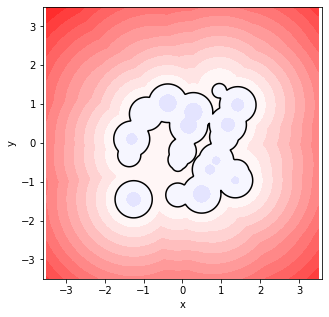

In [12]:
def balls_sdf(balls, p, ball_r=0.5):
  dists = norm(p-balls.pos)-ball_r
  return dists.min()

p = jax.random.normal(key, [1000, 3])
print( jax.vmap(partial(balls_sdf, balls))(p).shape )

show_slice(partial(balls_sdf, balls), z=0.0);

In [1]:
def scene_sdf(balls, p, ball_r=0.05, c=8.0):
  dists = norm(p-balls.pos)-ball_r
  # balls_dist = -jax.nn.logsumexp(-dists*c)/c  # softmin
  balls_dist = dists.min()
  floor_dist = p[1]+3.0  # floor is at y==-3.0
  return jp.minimum(balls_dist, floor_dist)  

# By using softmin our function stops satisfying conditions for SFD (it works on a boundary, bud modification affact function in other regions)  - Mery's idea
show_slice(partial(scene_sdf, balls), z=0.0)

NameError: name 'show_slice' is not defined

In [14]:
def raycast(sdf, p0, dir, step_n=150): #50
  def f(_, p):
    return p+sdf(p)*dir
  return jax.lax.fori_loop(0, step_n, f, p0)

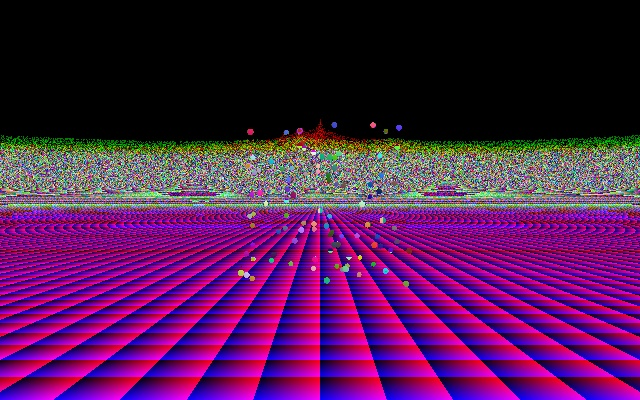

In [15]:
world_up = jp.array([0., 1., 0.])

def camera_rays(forward, view_size, fx=0.6):
  right = jp.cross(forward, world_up)
  down = jp.cross(right, forward)
  R = normalize(jp.vstack([right, down, forward]))
  w, h = view_size
  fy = fx/w*h
  y, x = jp.mgrid[fy:-fy:h*1j, -fx:fx:w*1j].reshape(2, -1)
  return normalize(jp.c_[x, y, jp.ones_like(x)]) @ R

w, h = 640, 400
pos0 = jp.float32([0, 0, 10.0])
ray_dir = camera_rays(-pos0, view_size=(w, h))
sdf = partial(scene_sdf, balls)
hit_pos = jax.vmap(partial(raycast, sdf, pos0))(ray_dir)
imshow(hit_pos.reshape(h, w, 3)%1.0)


# Camera looking in the distacnce - rgb noise is from rays that didn't travell to infinity (and ), increase marching steps

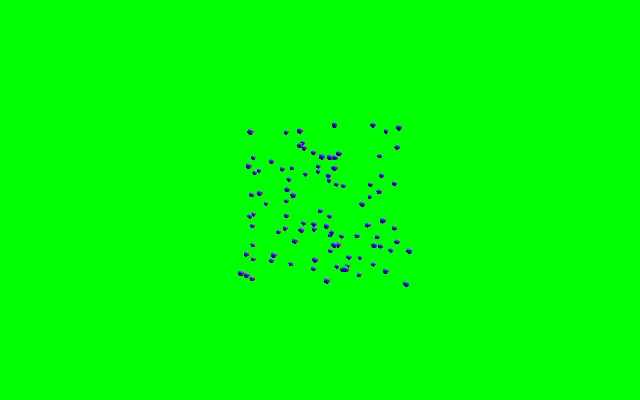

In [16]:
raw_normal = jax.vmap(jax.grad(sdf))(hit_pos)
imshow(raw_normal.reshape(h, w, 3))

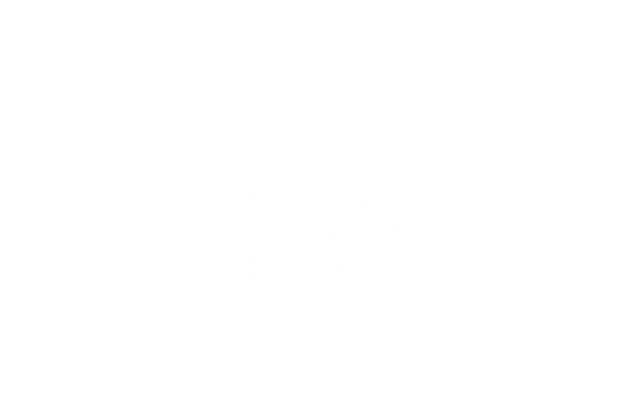

In [17]:
imshow(norm(raw_normal).reshape(h, w))

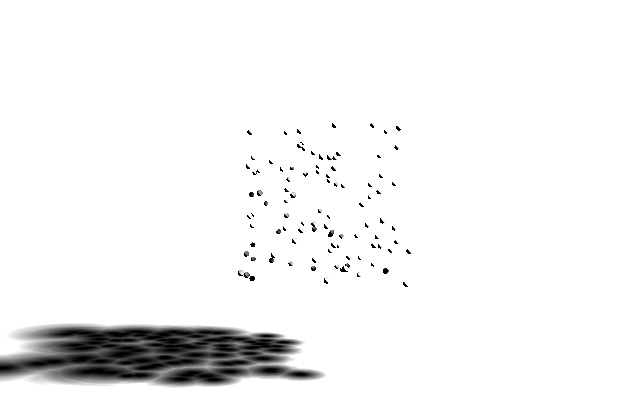

In [18]:
def cast_shadow(sdf, light_dir, p0, step_n=50, hardness=8.0):
  def f(_, carry):
    t, shadow = carry
    h = sdf(p0+light_dir*t)
    return t+h, jp.clip(hardness*h/t, 0.0, shadow)
  return jax.lax.fori_loop(0, step_n, f, (1e-2, 1.0))[1]

light_dir = normalize(jp.array([1.1, 1.0, 0.2]))
shadow = jax.vmap(partial(cast_shadow, sdf, light_dir))(hit_pos)
imshow(shadow.reshape(h, w))

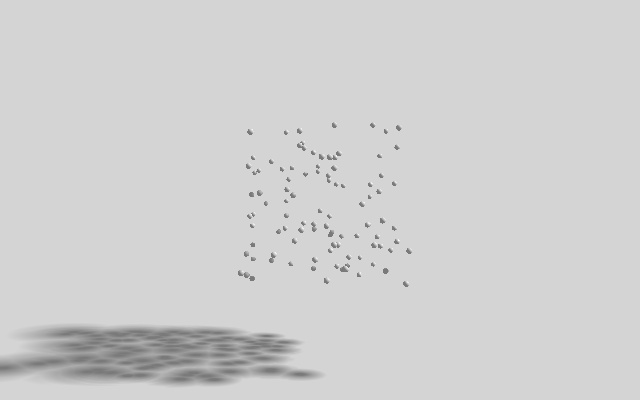

In [19]:
def shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir):
  ambient = norm(raw_normal)
  normal = raw_normal/ambient
  diffuse = normal.dot(light_dir).clip(0.0)*shadow
  half = normalize(light_dir-ray_dir)
  spec = 0.3 * shadow * half.dot(normal).clip(0.0)**200.0
  light = 0.7*diffuse+0.2*ambient
  return surf_color*light + spec

f = partial(shade_f, jp.ones(3), light_dir=light_dir)
frame = jax.vmap(f)(shadow, raw_normal, ray_dir)
frame = frame**(1.0/2.2)  # gamma correction
imshow(frame.reshape(h, w, 3))

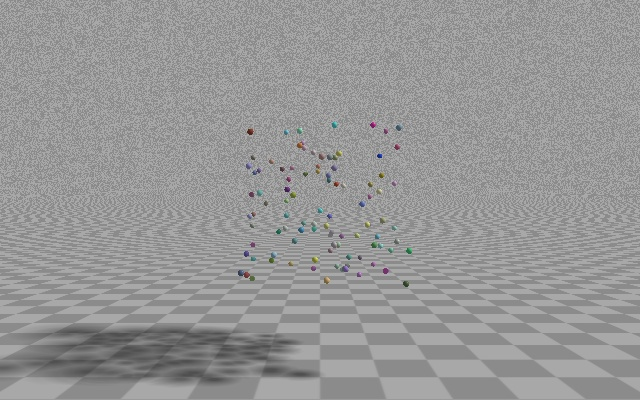

In [34]:
def scene_sdf(balls, p, ball_r=0.05, c=8.0, with_color=False):
  dists = norm(p-balls.pos)-ball_r
  balls_dist = dists.min() #-jax.nn.logsumexp(-dists*c)/c
  floor_dist = p[1]+3.0  # floor is at y==-3.0
  min_dist = jp.minimum(balls_dist, floor_dist)
  if not with_color:
    return min_dist
  x, y, z = jp.tanh(jp.sin(p*jp.pi)*20.0)
  floor_color = (0.5+(x*z)*0.1)*jp.ones(3)
  balls_color = jax.nn.softmax(-dists*c) @ balls.color
  color = jp.choose(jp.int32(floor_dist < balls_dist),
            [balls_color, floor_color], mode='clip')
  return min_dist, color

color_sdf = partial(scene_sdf, balls, with_color=True)
_, surf_color = jax.vmap(color_sdf)(hit_pos)
f = partial(shade_f, light_dir=light_dir)
frame = jax.vmap(f)(surf_color, shadow, raw_normal, ray_dir)
frame = frame**(1.0/2.2)  # gamma correction
imshow(frame.reshape(h, w, 3))

Compilation time:
CPU times: user 1.25 s, sys: 6.98 ms, total: 1.26 s
Wall time: 478 ms


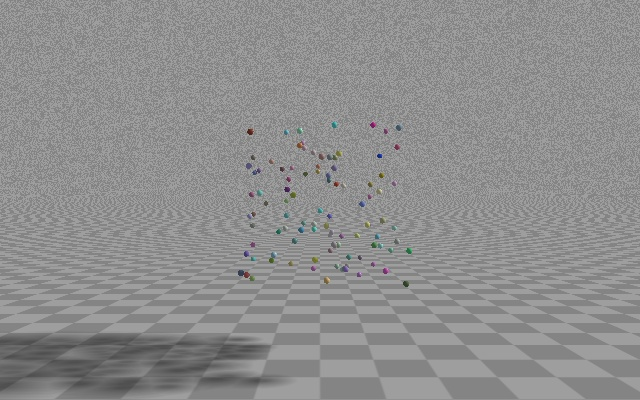

In [35]:
def _render_scene(balls,
                  view_size=(640, 400),
                  target_pos=jp.array([0.0, 0.0, 0.0]),
                  camera_pos=jp.array([0, 0, 10.0]), #[4.0, 3.0, 4.0]
                  light_dir=jp.array([1.5, 1.0, 0.0]),
                  sky_color=jp.array([0.3, 0.4, 0.7])):
  sdf = partial(scene_sdf, balls)
  normal_color_f = jax.grad(partial(sdf, with_color=True), has_aux=True)
  light_dir = normalize(light_dir)

  def render_ray(ray_dir):
    hit_pos = raycast(sdf, camera_pos, ray_dir)
    shadow = cast_shadow(sdf, light_dir, hit_pos)
    raw_normal, surf_color = normal_color_f(hit_pos)
    color = shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir)
    # escape = jp.tanh(jp.abs(hit_pos).max()-20.0)*0.5+0.5
    # color = color + (sky_color-color)*escape
    return color**(1.0/2.2)  # gamma correction

  ray_dir = camera_rays(target_pos-camera_pos, view_size)
  color = jax.vmap(render_ray)(ray_dir)
  w, h = view_size
  return color.reshape(h, w, 3)

render_scene = jax.jit(_render_scene)

print('Compilation time:')
frame=%time render_scene(balls).block_until_ready()
imshow(frame)

In [36]:
def random_balls():
  key = jax.random.PRNGKey(np.random.randint(1e6))
  return create_balls(key)

!nvidia-smi -L
print('\nNo JIT render time:')
%timeit _render_scene(random_balls()).block_until_ready()
print('\nJIT render time:')
%timeit render_scene(random_balls()).block_until_ready()

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-735f0567-3dbb-72de-71e3-a35c63c87b62)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-aa99361e-ab40-0240-f6b7-687262e10348)

No JIT render time:
231 ms ± 7.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

JIT render time:
29.3 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%time
pos = jp.float32([[1, 0], [0, 1], [2, 1], [2, 2.5], 
                  [4, 0], [4, 1.4], [5, 2.5], [6, 0], [6, 1.4],
                  [8, 0], [10, 0], [9, 1.2], [8, 2.4], [10, 2.4]])*0.7
color = jp.float32([[0.1,0.3,0.9]]*4 + [[0.01,0.4,0.3]]*5 + [[0.8,0.2,1.0]]*5)
pos = jp.c_[pos-pos.ptp(0)/2, 0.0*pos[:,:1]]
s0 = dict(
    balls=Balls(pos, color),
    camera_pos=jp.array([0.0,2.0, 7]),
    light_dir=jp.float32([1, 1, 1]))

keys = iter(jax.random.split(key, 10))
s1 = dict(
    balls=create_balls(next(keys), len(pos), R=10.0),
    camera_pos=jp.array([-15.0,8.0, -10]),
    light_dir=jp.float32([-5, 1, -1]))
s2 = dict(
    balls=create_balls(next(keys), len(pos), R=10.0),
    camera_pos=jp.array([15.0,9.0, -10]),
    light_dir=jp.float32([-3, 1, 1]))

def cubic(t, a, b, c, d):
  s = 1.0-t
  return s*s*(s*a + 3*t*b) + t*t*(3*s*c + t*d)

def render_frame(t):
  t = t*t*(3-2*t)  # easing
  s = jax.tree_map(partial(cubic, t), s0, s1, s2, s0)
  return render_scene(**s)

animate(render_frame, 10)

CPU times: user 11.4 s, sys: 680 ms, total: 12.1 s
Wall time: 11.3 s


In [19]:
img, dimg = jax.jvp(render_frame, (0.005,), (0.5,))
animate(lambda t: img+jp.sin(8*t*jp.pi)*t*dimg, 3)